## Setup

In [1]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import torch
import string
import unicodedata
# try to load the json data
import json
import torch.nn as nn
import time
import torch.optim as optim
import torch.nn.functional as F
from random import choice, choices, shuffle, randint

import matplotlib.pyplot as plt

assert torch.cuda.is_available()

     |████████████████████████████████| 993kB 9.6MB/s 


In [4]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#https://drive.google.com/open?id=1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content with length "{}"'.format(len(downloaded.GetContentString())))

jsonObject = json.loads(downloaded.GetContentString())

print(type(jsonObject))
print(len(jsonObject))
print(jsonObject[0])

all_categories = []
articles_dict = dict()
for article in jsonObject:
    category = article["category"]
    if category not in all_categories:
        all_categories.append(category)
        articles_dict[category] = []
    articles_dict[category].append(article)
    
keep = ["Mathematics", "Physics", "Computer Science"]
for i in range(len(all_categories)-1, -1, -1):
    if all_categories[i] not in keep:
        cat = all_categories.pop(i)
        del articles_dict[cat]
    
n_categories = len(articles_dict.keys())

weights_all_categories = []
for category in all_categories:
    print("{} : {}".format(category, len(articles_dict[category])))
    weights_all_categories.append(len(articles_dict[category])/len(jsonObject))
print(weights_all_categories)

n_letters = len(string.printable)+1

def lineToCNNTensor(text):
    tensor = torch.zeros(1, len(text), n_letters)
    # this is splitting letters with accents into letter + accent
    normalized = unicodedata.normalize("NFD", text)
    for idx, char in enumerate(normalized):
        if unicodedata.category(char) == "Mn":
            continue
        # characters not in string.printable get a "pos" of -1,
        # which goes into the "trash" coordinate
        pos = string.printable.find(char)
        tensor[0, idx, pos] = 1
    return tensor

print(lineToCNNTensor("Ro"))
print(lineToCNNTensor("ro").shape)

Downloaded content with length "669380879"
<class 'list'>
573371
{'id': 'http://arxiv.org/abs/1904.03835v4', 'category': 'Physics', 'subject': 'astro-ph.CO', 'title': 'Kaon oscillations and baryon asymmetry of the universe', 'abstract': 'Baryon asymmetry of the universe (BAU) is naturally explained with\n$K^0-K^{0\'}$ oscillations of a newly developed mirror-matter model and new\nunderstanding of quantum chromodynamics (QCD) phase transitions. A consistent\npicture for the origin of both BAU and dark matter is presented with the aid of\n$n-n\'$ oscillations of the new model. The global symmetry breaking transitions\nin QCD are proposed to be staged depending on condensation temperatures of\nstrange, charm, bottom, and top quarks in the early universe. The long-standing\nBAU puzzle can then be understood with $K^0-K^{0\'}$ oscillations that occur at\nthe stage of strange quark condensation and baryon number violation via a\nnon-perturbative instanton-like (coined "quarkiton") process. S

In [5]:
training_percentage = 0.8
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]
    
def print_statistics(use_first_characters):
    print("With regards to abstracts of length at least {},".format(use_first_characters))
    for cat in all_categories:
        print("\t{:6} abstracts for {}".format(
                len(list(filter(lambda art: len(art["abstract"]) >= use_first_characters, articles_dict[cat]))),
                cat))
              
print_statistics(300)

With regards to abstracts of length at least 300,
	202723 abstracts for Physics
	140984 abstracts for Computer Science
	136506 abstracts for Mathematics


In [0]:
class leakyCNN_model(nn.Module):
    def __init__(self, abstract_length, characters_used, output_size):
        super(leakyCNN_model, self).__init__()

        self.abstract_length = abstract_length
        self.characters_used = characters_used
        self.output_size = output_size
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 6, 10)
        self.conv2 = nn.Conv2d(6, 12, 10)
        # final dimensions
        fin_dim = (((abstract_length-9)//2-9)//2, ((characters_used-9)//2-9)//2)
        self.fin_dim = fin_dim
        self.linear1 = nn.Linear(12*fin_dim[0]*fin_dim[1], 4*fin_dim[0]*fin_dim[1])
        self.linear2 = nn.Linear(4*fin_dim[0]*fin_dim[1], output_size)

    def forward(self, x):
        # let AL stand for abstract length and CU for characters used
        ### each batch element has size (1, AL, CU)
        x = F.leaky_relu(self.conv1(x))
        ### each batch element has size (6, AL-10+1, CU-10+1)
        x = self.pool(x)
        ### each batch element has size (6, (AL-9)//2, (CU-9)//2)
        x = F.leaky_relu(self.conv2(x))
        ### size (12, (AL-9)//2-9, (CU-9)//2-9)
        x = self.pool(x)
        ### size (12, ((AL-9)//2-9)//2, ((CU-9)//2-9))//2)
        x = x.view(-1, 12*self.fin_dim[0]*self.fin_dim[1])
        x = self.linear2(F.leaky_relu(self.linear1(x)))
        return x

def categoryFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
  
def topTwoFromOutput(out):
    top_n, top_i = out.topk(2)
    top_1_i = top_i[0, 0].item()
    top_2_i = top_i[0, 1].item()
    return top_1_i, top_2_i

def randomCNNTrainingExample(use_first_n_characters=-1):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(training_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToCNNTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()
  
def randomCNNTrainingSection(use_first_n_characters):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    abstract = ""
    while len(abstract) < use_first_n_characters:
        article = choice(training_dict[category])
        abstract = article["abstract"]
    start_slice = randint(0, len(abstract)-use_first_n_characters)
    abs_slice = abstract[start_slice : start_slice+use_first_n_characters]
    abstract_tensor = lineToCNNTensor(abs_slice)
    return category, abs_slice, category_tensor.cuda(), abstract_tensor.cuda()
  
def randomWeightedCNNTrainingExample(use_first_n_characters=-1):
    # use the random.choices function with the weights computed earlier
    category = choices(all_categories, weights = weights_all_categories, k = 1)[0]
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).cuda()
    article = choice(training_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToCNNTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()

randomCNNTrainingExample()

def randomCNNTestingExample(use_first_n_characters=-1):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(testing_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToCNNTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()
  
randomCNNTestingExample()

def plot_losses(all_losses):
    plt.figure()
    plt.plot(all_losses)
    
def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)

# LEAKY model

## (1) Standard settings (76% / 93%)


With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	153542 abstracts for Mathematics
100 0.5% (0.0m 5.643807888031006s) 1.103 / Computer Science V
200 1.0% (0.0m 11.377392530441284s) 1.087 / Computer Science X Physics
300 1.5% (0.0m 17.07352590560913s) 1.083 / Computer Science X Physics
400 2.0% (0.0m 22.696733951568604s) 1.088 / Computer Science X Mathematics
500 2.5% (0.0m 28.319401741027832s) 1.13 / Computer Science X Physics
600 3.0% (0.0m 33.90737795829773s) 1.139 / Mathematics X Physics
700 3.5% (0.0m 39.51240921020508s) 1.081 / Physics V
800 4.0% (0.0m 45.09817314147949s) 1.01 / Mathematics X Physics
900 4.5% (0.0m 50.71617078781128s) 1.056 / Computer Science X Physics
1000 5.0% (0.0m 56.376322507858276s) 1.014 / Physics V
1100 5.5% (1.0m 2.020388603210449s) 1.118 / Mathematics X Computer Science
1200 6.0% (1.0m 7.6795244216918945s) 1.025 / Computer Science X Mathematics
1300 6.5% (1.0m 13.447464227676392s) 0.93

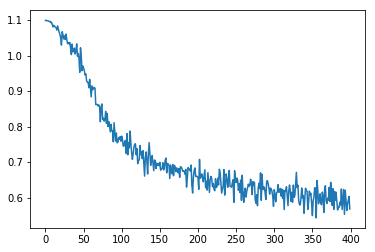

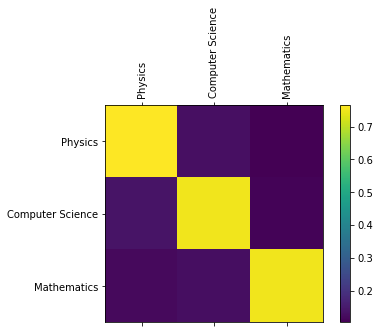

tensor([[76., 13., 10.],
        [13., 75., 10.],
        [12., 12., 75.]])


In [8]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.005

n_batch_iters = 20000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## (2) Double lr (76% / 93%) based on (1)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	153542 abstracts for Mathematics
100 0.5% (0.0m 5.715332269668579s) 1.1 / Computer Science X Mathematics
200 1.0% (0.0m 11.446059226989746s) 1.092 / Physics V
300 1.5% (0.0m 17.102853536605835s) 1.108 / Physics X Computer Science
400 2.0% (0.0m 22.711814880371094s) 1.059 / Computer Science X Physics
500 2.5% (0.0m 28.349235773086548s) 1.093 / Computer Science V
600 3.0% (0.0m 33.97802186012268s) 1.085 / Physics X Mathematics
700 3.5% (0.0m 39.62615609169006s) 1.055 / Computer Science X Mathematics
800 4.0% (0.0m 45.24169993400574s) 1.136 / Computer Science V
900 4.5% (0.0m 50.86518907546997s) 1.052 / Physics V
1000 5.0% (0.0m 56.481689453125s) 1.183 / Computer Science X Physics
1100 5.5% (1.0m 2.1175894737243652s) 0.9578 / Computer Science X Physics
1200 6.0% (1.0m 7.75346827507019s) 1.107 / Computer Science X Physics
1300 6.5% (1.0m 13.488268375396729s) 1.06 / Physic

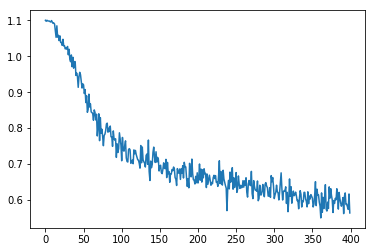

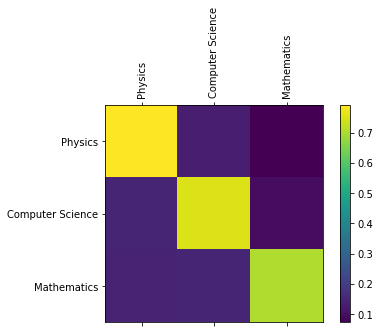

tensor([[79., 13.,  7.],
        [14., 75.,  9.],
        [14., 14., 70.]])


In [9]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.01

n_batch_iters = 20000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## (3) Increase batch size (76% / 93%) compared to (1)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	153542 abstracts for Mathematics
100 0.5% (0.0m 8.114087343215942s) 1.097 / Physics X Computer Science
200 1.0% (0.0m 16.300591230392456s) 1.095 / Physics V
300 1.5% (0.0m 24.62841272354126s) 1.082 / Computer Science X Mathematics
400 2.0% (0.0m 32.79647874832153s) 1.097 / Computer Science X Mathematics
500 2.5% (0.0m 40.93949818611145s) 1.074 / Computer Science X Physics
600 3.0% (0.0m 49.02724862098694s) 1.106 / Physics X Computer Science
700 3.5% (0.0m 57.197770833969116s) 1.078 / Computer Science X Mathematics
800 4.0% (1.0m 5.439322233200073s) 1.071 / Computer Science V
900 4.5% (1.0m 13.52731704711914s) 1.063 / Computer Science X Physics
1000 5.0% (1.0m 21.604560613632202s) 1.096 / Computer Science V
1100 5.5% (1.0m 29.77825379371643s) 1.099 / Mathematics X Physics
1200 6.0% (1.0m 37.954689502716064s) 1.026 / Mathematics X Computer Science
1300 6.5% (1.0m 46.127

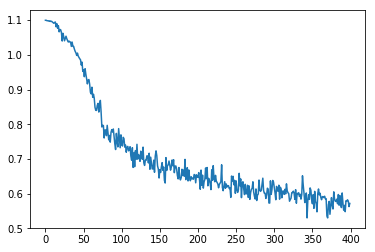

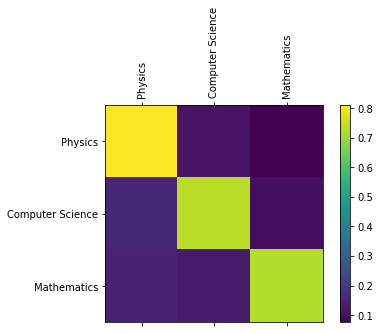

tensor([[81., 11.,  7.],
        [16., 73., 10.],
        [14., 12., 72.]])


In [10]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.005

n_batch_iters = 20000
batch_size = 35
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## (4) Train twice as long (78% / 94%) compared to (1)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	153542 abstracts for Mathematics
100 0.25% (0.0m 5.734389781951904s) 1.101 / Computer Science V
200 0.5% (0.0m 11.42848825454712s) 1.101 / Mathematics X Computer Science
300 0.75% (0.0m 17.10694718360901s) 1.099 / Computer Science X Mathematics
400 1.0% (0.0m 22.795934200286865s) 1.094 / Mathematics X Computer Science
500 1.25% (0.0m 28.5151948928833s) 1.068 / Computer Science V
600 1.5% (0.0m 34.22980809211731s) 1.079 / Computer Science X Mathematics
700 1.75% (0.0m 39.93141150474548s) 1.097 / Physics X Mathematics
800 2.0% (0.0m 45.648223876953125s) 1.036 / Mathematics V
900 2.25% (0.0m 51.49521493911743s) 1.022 / Computer Science X Physics
1000 2.5% (0.0m 57.324535608291626s) 1.145 / Physics X Mathematics
1100 2.75% (1.0m 3.0823631286621094s) 1.115 / Computer Science V
1200 3.0% (1.0m 8.832595586776733s) 1.067 / Mathematics X Physics
1300 3.25% (1.0m 14.53092837333

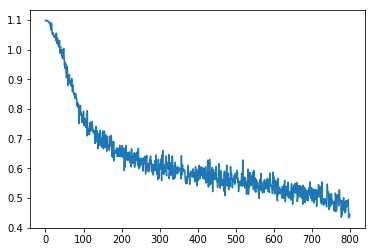

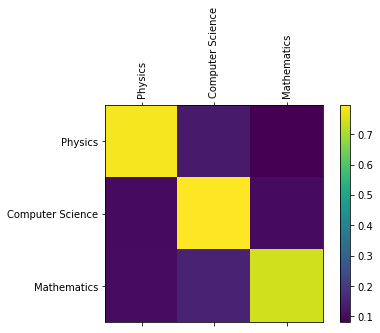

tensor([[78., 13.,  8.],
        [10., 79., 10.],
        [10., 15., 74.]])


In [11]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.005

n_batch_iters = 40000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## (5) Double lr (78% / 94%) compared to (4)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	153542 abstracts for Mathematics
100 0.25% (0.0m 5.621713399887085s) 1.1 / Computer Science V
200 0.5% (0.0m 11.278741121292114s) 1.102 / Computer Science X Physics
300 0.75% (0.0m 16.879334926605225s) 1.082 / Physics V
400 1.0% (0.0m 22.517565727233887s) 1.083 / Computer Science X Mathematics
500 1.25% (0.0m 28.12347960472107s) 1.091 / Physics X Computer Science
600 1.5% (0.0m 33.734896659851074s) 1.092 / Computer Science X Physics
700 1.75% (0.0m 39.324514865875244s) 1.077 / Mathematics X Physics
800 2.0% (0.0m 44.89475178718567s) 1.101 / Computer Science X Mathematics
900 2.25% (0.0m 50.550840616226196s) 0.9876 / Computer Science V
1000 2.5% (0.0m 56.219688177108765s) 1.188 / Physics X Mathematics
1100 2.75% (1.0m 1.826343059539795s) 1.159 / Physics X Computer Science
1200 3.0% (1.0m 7.393808126449585s) 0.98 / Physics X Mathematics
1300 3.25% (1.0m 13.0071566104888

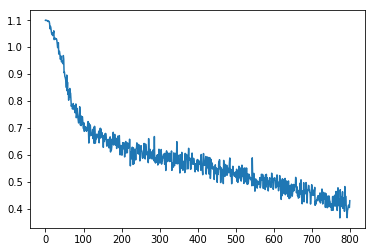

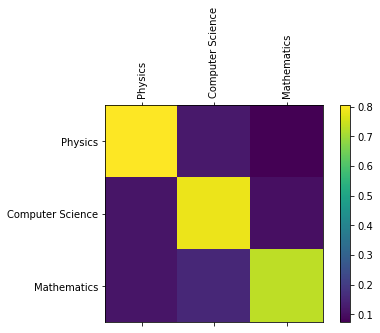

tensor([[80., 12.,  7.],
        [11., 78., 10.],
        [11., 15., 73.]])


In [12]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.01

n_batch_iters = 40000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## (6) Double training (78% / 94%) compared to (5)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	153542 abstracts for Mathematics
100 0.12% (0.0m 5.786553382873535s) 1.086 / Computer Science X Mathematics
200 0.25% (0.0m 11.6183762550354s) 1.099 / Mathematics V
300 0.38% (0.0m 17.502737045288086s) 1.102 / Physics X Mathematics
400 0.5% (0.0m 23.369967937469482s) 1.104 / Computer Science X Physics
500 0.62% (0.0m 29.133506298065186s) 1.084 / Mathematics X Physics
600 0.75% (0.0m 34.91365027427673s) 1.069 / Mathematics X Physics
700 0.88% (0.0m 40.64755058288574s) 1.087 / Computer Science X Physics
800 1.0% (0.0m 46.50586009025574s) 1.1 / Physics V
900 1.12% (0.0m 52.40308237075806s) 1.079 / Computer Science V
1000 1.25% (0.0m 58.17078948020935s) 0.9739 / Mathematics X Physics
1100 1.38% (1.0m 3.939192533493042s) 1.123 / Computer Science V
1200 1.5% (1.0m 9.721019506454468s) 0.9623 / Physics X Mathematics
1300 1.62% (1.0m 15.473581552505493s) 1.116 / Computer Scien

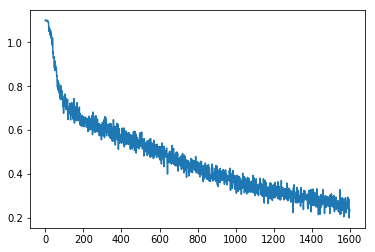

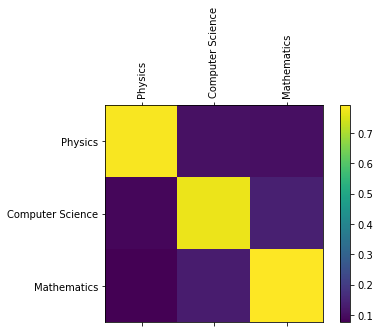

tensor([[78., 10., 10.],
        [ 8., 77., 14.],
        [ 7., 13., 79.]])


In [14]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.01

n_batch_iters = 80000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)